<a href="https://colab.research.google.com/github/letddo/flower_classification/blob/main/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 참고 자료

- kaggle api colab으로 사용하기 - https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

- image to dataset - https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6

### 1. kaggle api colab으로 사용하기
- 이제 다운도 안받아도 된다

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files 
files.upload() # kaggle 홈페이지 > 오른쪽 위 프로필 > Settings > Create new token 해서 다운받은 json 파일
# 본인 '각자' 다른 파일을 넣어줘야 합니다!

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"baksuhyun","key":"f5270d215c416a5b097995b6b23d4a86"}'}

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d utkarshsaxenadn/flower-classification-5-classes-roselilyetc
# kaggle competitions download -c tpu-getting-started

100% 948M/949M [00:47<00:00, 22.6MB/s]
100% 949M/949M [00:47<00:00, 21.0MB/s]


In [ ]:
!unzip flower-classification-5-classes-roselilyetc.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1500).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1501).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1502).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1503).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1504).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1505).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1506).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1507).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1508).jpeg  
  inflating: Flower Classification/Flower Classification/Training Data/Lily/Lily (1509).jpeg  
  inflating: F

---

### 2. 데이터 다루기

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50, preprocess_input
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random

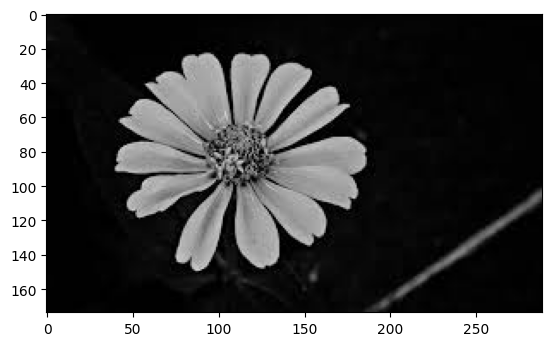

In [ ]:
# 경로 체크 용

img = mpimg.imread('/content/Flower Classification/Flower Classification/Training Data/Daisy/Daisy (1).jpeg')
plt.imshow(img)

In [ ]:
IMG_WIDTH=224
IMG_HEIGHT=224

In [ ]:
# img -> dataset 함수
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread(image_path) 
            b, g, r = cv2.split(image)
            image = cv2.merge([r,g,b])
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
        
        print("Done " + dir1)
    
    
    target_dict={k: v for v, k in enumerate(np.unique(class_name))} 
    target_val=[target_dict[class_name[i]] for i in range(len(class_name))] 
    img_data_array = np.array(img_data_array) # araay -> nparray로 바꾸는 과정 
    return img_data_array, target_val

In [ ]:
x_train, t_train =create_dataset('/content/Flower Classification/Flower Classification/Training Data')
x_test, t_test =create_dataset('/content/Flower Classification/Flower Classification/Testing Data')
x_val, t_val =create_dataset('/content/Flower Classification/Flower Classification/Validation Data')

Done Rose
Done Daisy
Done Lavender
Done Lily
Done Sunflower
Done Rose
Done Daisy
Done Lavender
Done Lily
Done Sunflower
Done Rose
Done Daisy
Done Lavender
Done Lily
Done Sunflower


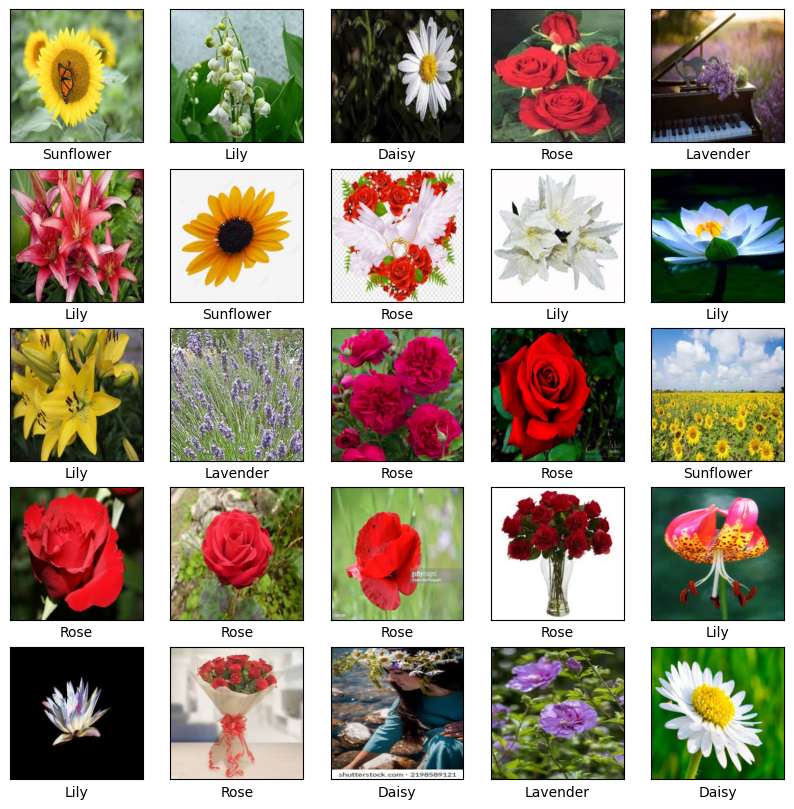

In [ ]:
# data test

label_names = ['Daisy', 'Lavender', 'Lily', 'Rose', 'Sunflower']
plt.figure(figsize=(10,10))

for i in range(25):
    l = random.randrange(1,5000)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[l])
    plt.xlabel(label_names[t_train[l]])
plt.show()

In [ ]:
t_train = to_categorical(t_train)
t_test = to_categorical(t_test)
t_val = to_categorical(t_val)
print('One-hot Vector 적용 후 t_val shape : ', t_val.shape)
print('One-hot Vector 적용 후 t_train shape : ', t_train.shape)
print('One-hot Vector 적용 후 t_test shape : ', t_test.shape)

# 적용을 하지 않으면 아무래도 list 상태인 것 같다 

One-hot Vector 적용 후 t_val shape :  (2500, 5)
One-hot Vector 적용 후 t_train shape :  (5000, 5)
One-hot Vector 적용 후 t_test shape :  (958, 5)


## (0) 데이터 늘리기 beta

- 문제점: 메모리오류 / 수정할 것: 쪼개서 추가하기
- 사용할때 위의 코드에서 train dataset을 만드는 과정은 주석처리하고 사용해주시는게 좋습니다.

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_num = 4 # 데이터를 불릴 개수 (*n배)

In [ ]:
# img -> dataset 제너레이트 하면서 
def create_dataset_with_g(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread(image_path) 
            b, g, r = cv2.split(image)
            image = cv2.merge([r,g,b])
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)

            for i in range(data_num):
              for l in show_aug_image(image, data_generator):
                img_data_array.append(l)
                class_name.append(dir1)


        print("Done " + dir1)
    
    
    target_dict={k: v for v, k in enumerate(np.unique(class_name))} 
    target_val=[target_dict[class_name[i]] for i in range(len(class_name))] 
    img_data_array = np.array(img_data_array) # araay -> nparray로 바꾸는 과정 
    return img_data_array, target_val

In [ ]:
x_train, t_train =create_dataset_with_g('/content/Flower Classification/Flower Classification/Training Data')

In [ ]:
t_train = to_categorical(t_train)
print('One-hot Vector 적용 후 t_train shape : ', t_train.shape)

## (1) 기존 모델

### 3. model 부분

In [ ]:
# model 부분 

width = 200
height = 200
channel = 3

model = Sequential(name = 'CIFAR10_CNN')

model.add(Conv2D(filters=100, kernel_size=(2, 2), padding= 'same', activation= 'relu',
                input_shape=(width, height, channel)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=200, kernel_size=(2, 2), padding= 'same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=400, kernel_size=(2, 2), padding= 'same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "CIFAR10_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 100)     1300      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 200)     80200     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 200)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 400)       320400    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 400)      

### 4. 학습하기

In [ ]:
# 학습하기
model.fit(x_train, t_train, epochs=10, batch_size=10)

Epoch 1/10


ValueError: ignored

### 5. 성능 확인

In [ ]:
# 성능 확인
width = 200
height = 200
channel = 3

label_names = ['Daisy', 'Lavender', 'Lily', 'Rose', 'Sunflower']

for i in range(10):
    plt.figure(figsize=(2,2))

    l = random.randrange(1,900)
    
    output = model.predict(x_test[l].reshape(1, width, height, channel))
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[l].reshape(width, height, channel))
    
    print('예측 : ' + label_names[np.argmax(output)] + ' / 정답 : ' + label_names[np.argmax(t_test[l])])
    plt.show()

ValueError: ignored

<Figure size 200x200 with 0 Axes>

In [ ]:
# 모델 평가
loss, accuracy = model.evaluate(x_test, t_test, verbose=1)
print('test loss : ', round(loss, 6))
print('test accuracy : ', round(accuracy*100, 3), '%')

## (2) 강의 실습 모델1: ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200,200,3))

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(5, activation='softmax')(x) # Dense = 클래스

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# if one-hot -> loss = 'categorical_crossentropy'
# 1D or 정수 인코딩 대상 = sparse_categorical_crossentropy

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
history = model.fit(x_train, t_train, batch_size= 64, epochs=10, validation_data=(x_val, t_val), callbacks=[early_stopping])

Epoch 1/10
79/79 [==============================] - 38s 295ms/step - loss: 4.1923 - accuracy: 0.2894 - val_loss: 1.7225 - val_accuracy: 0.3484
Epoch 2/10
79/79 [==============================] - 23s 290ms/step - loss: 1.4832 - accuracy: 0.4312 - val_loss: 1.6689 - val_accuracy: 0.3480
Epoch 3/10
79/79 [==============================] - 23s 294ms/step - loss: 1.2452 - accuracy: 0.5060 - val_loss: 2.2978 - val_accuracy: 0.2472
Epoch 4/10
79/79 [==============================] - 23s 293ms/step - loss: 1.2270 - accuracy: 0.5202 - val_loss: 1.6001 - val_accuracy: 0.4296
Epoch 5/10
79/79 [==============================] - 19s 240ms/step - loss: 1.2251 - accuracy: 0.5478 - val_loss: 2.0215 - val_accuracy: 0.3480
Epoch 6/10
79/79 [==============================] - 19s 240ms/step - loss: 1.3188 - accuracy: 0.5416 - val_loss: 1.6908 - val_accuracy: 0.4316
Epoch 7/10
79/79 [==============================] - 23s 292ms/step - loss: 1.0648 - accuracy: 0.5940 - val_loss: 2.7137 - val_accuracy: 0.3648

In [ ]:
# 불러오기

# 학습을 시키지 않아도 됨 
from keras.models import load_model
model2 = load_model('/content/ResNet50_1.h5')

GoogleNet

In [ ]:
from keras.applications import inception_v3
model = inception_v3.InceptionV3(weights='imagenet', include_top=True)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

## (2) 강의 실습 모델3: VGG19Net




In [ ]:
from keras.applications.vgg19 import VGG19
tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model=VGG19();
model.summary();

574710816/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

### 5. 성능 확인

In [ ]:
# 성능 확인
width = 200
height = 200
channel = 3

label_names = ['Daisy', 'Lavender', 'Lily', 'Rose', 'Sunflower']

for i in range(10):
    plt.figure(figsize=(2,2))

    l = random.randrange(1,900)
    
    output = model.predict(x_test[l].reshape(1, width, height, channel))
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[l].reshape(width, height, channel))
    
    print('예측 : ' + label_names[np.argmax(output)] + ' / 정답 : ' + label_names[np.argmax(t_test[l])])
    plt.show()

NameError: ignored

<Figure size 200x200 with 0 Axes>

In [ ]:
# 모델 평가
loss, accuracy = model.evaluate(x_test, t_test, verbose=1)
print('test loss : ', round(loss, 6))
print('test accuracy : ', round(accuracy*100, 3), '%')

30/30 [==============================] - 3s 85ms/step - loss: 2.8319 - accuracy: 0.4384
test loss :  2.831933
test accuracy :  43.841 %


In [ ]:
# 학습된 모델 저장 

# https://tykimos.github.io/2017/06/10/Model_Save_Load/

from keras.models import load_model

model.save('/content/ResNet501_1.h5')
